Fig. 3f

In [2]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

from matplotlib.lines import Line2D

from scipy.stats import ttest_ind

from config import *
from CP4.make_composites.SM_contrast.make_SM_contrast_composites import get_files_contrast_composites
from CP4.make_composites.SM_contrast.b1_make_var_field_anomaly_contrast import load_contrast_composite_mean_ano_field
from CP4.make_composites.SM_contrast.significance.b_compute_var_field_significance_contrast_merge import load_contrast_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [3]:
coords = [[(10., 18.), (-20., -10.)], [(10.,18.), (-14., -4.)], [(10.,18.), (-8., 2.)], [(10.,18.), (-2.,8.)], [(8.,16.), (8.,18.)]]

In [4]:
ds='CP4A'
res=4
var_ref='twb'
var='twb'
window=6
y0=1997
y1=2006
months=[5, 6, 7, 8, 9]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.   # km2
max_hw_size=1000000.   # km2
sw=[4., 4.]
tw=[-72, 72]
n_days=3
meth='cc3d'
cnty=26
samtime=[19, 19]
length_bounds=[5, 200]  # km
pvalue=0.01  # km
size_lengths=[25, 150]
flabel='f'

In [5]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

if var == 'twb':
    unit = '$^\circ$C'

lengths_ = str(size_lengths[0]) + 'km_' + str(size_lengths[1]) + 'km'
ave_lens = np.arange(length_bounds[0], length_bounds[1]+0.5, 0.5)   # radius

In [8]:
#~ Get data

pvalues = load_contrast_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, 'small', size_lengths[0])

xs = np.linspace(-pvalues.shape[0]/2, pvalues.shape[0]/2, pvalues.shape[0])
ys = np.linspace(-pvalues.shape[1]/2, pvalues.shape[1]/2, pvalues.shape[1])

xc = (xs[-1]-xs[0]) / 2 + xs[0]
yc = (ys[-1]-ys[0]) / 2 + ys[0]

xsm, ysm = np.meshgrid(xs, ys)

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values

sizes = {'small': size_lengths[0], 'large': size_lengths[1]}

out_anos_disc_all = {}
months_sizes = {}

for size, size_length in sizes.items():
    out_anos = []
    months_size = []

    for icoord, coord in enumerate(coords):
        lat_range = coord[0]
        lon_range = coord[1]

        filenames = get_files_contrast_composites(ds, res, var_ref, y0, y1, months, lat_range, lon_range, min_hw_size, max_hw_size, t_thresh, q_thresh, n_days, meth, cnty, size_lengths)

        ds_ano = load_contrast_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

        print('{0}: N={1}'.format(coord, ds_ano.shape[0]))

        out_anos.append(ds_ano)

    out_anos = xr.concat(out_anos, dim='n')

    n_hhee = out_anos.shape[0]

    out_ano_lens = []

    for ave_len in ave_lens:

        r = ave_len / 4.4  # nb of grid points

        disc_mask = np.broadcast_to(distloc <= r, out_anos.shape)

        out_anos_disc = ma.masked_array(out_anos.values, ~disc_mask)
        out_anos_disc = ma.filled(out_anos_disc, fill_value=np.nan)

        out_anos_disc_ = np.nanmean(out_anos_disc, axis=1)  # spatial mean
        out_anos_disc_ = np.nanmean(out_anos_disc_, axis=1)  # spatial mean

        out_ano_lens.append(out_anos_disc_)

    out_ano_lens = np.asarray(out_ano_lens)

    out_anos_disc_all[size] = out_ano_lens


disc_mean_small = out_anos_disc_all['small'].mean(axis=1)
disc_std_small = out_anos_disc_all['small'].std(axis=1)
disc_mean_large = out_anos_disc_all['large'].mean(axis=1)
disc_std_large = out_anos_disc_all['small'].std(axis=1)

disc_mean_diff = disc_mean_small - disc_mean_large

ttest_disc = ttest_ind(out_anos_disc_all['small'], out_anos_disc_all['large'], axis=1, alternative='two-sided', equal_var=False)  # great>

pvals = ttest_disc[1]
sig = pvals[pvals <= pvalue]
nosig = pvals[pvals > pvalue]

imin = np.argmax(pvals)
ichange = np.argmax(sig)  # location where smaller > larger becomes larger > smaller

isigsmall = np.arange(ichange)
isiglarge = np.arange(np.where(pvals==sig[ichange])[0][0], len(pvals), 1)
inosigsmall = np.arange(ichange, imin, 1)
inosiglarge = np.arange(imin, np.where(pvals==sig[ichange])[0][0], 1)

[(10.0, 18.0), (-20.0, -10.0)]: N=18
[(10.0, 18.0), (-14.0, -4.0)]: N=24
[(10.0, 18.0), (-8.0, 2.0)]: N=24
[(10.0, 18.0), (-2.0, 8.0)]: N=30
[(8.0, 16.0), (8.0, 18.0)]: N=27


/tmp/ipykernel_1140/4263176039.py:51: RuntimeWarning: Mean of empty slice
  out_anos_disc_ = np.nanmean(out_anos_disc, axis=1)  # spatial mean


[(10.0, 18.0), (-20.0, -10.0)]: N=18
[(10.0, 18.0), (-14.0, -4.0)]: N=24
[(10.0, 18.0), (-8.0, 2.0)]: N=24
[(10.0, 18.0), (-2.0, 8.0)]: N=30
[(8.0, 16.0), (8.0, 18.0)]: N=27


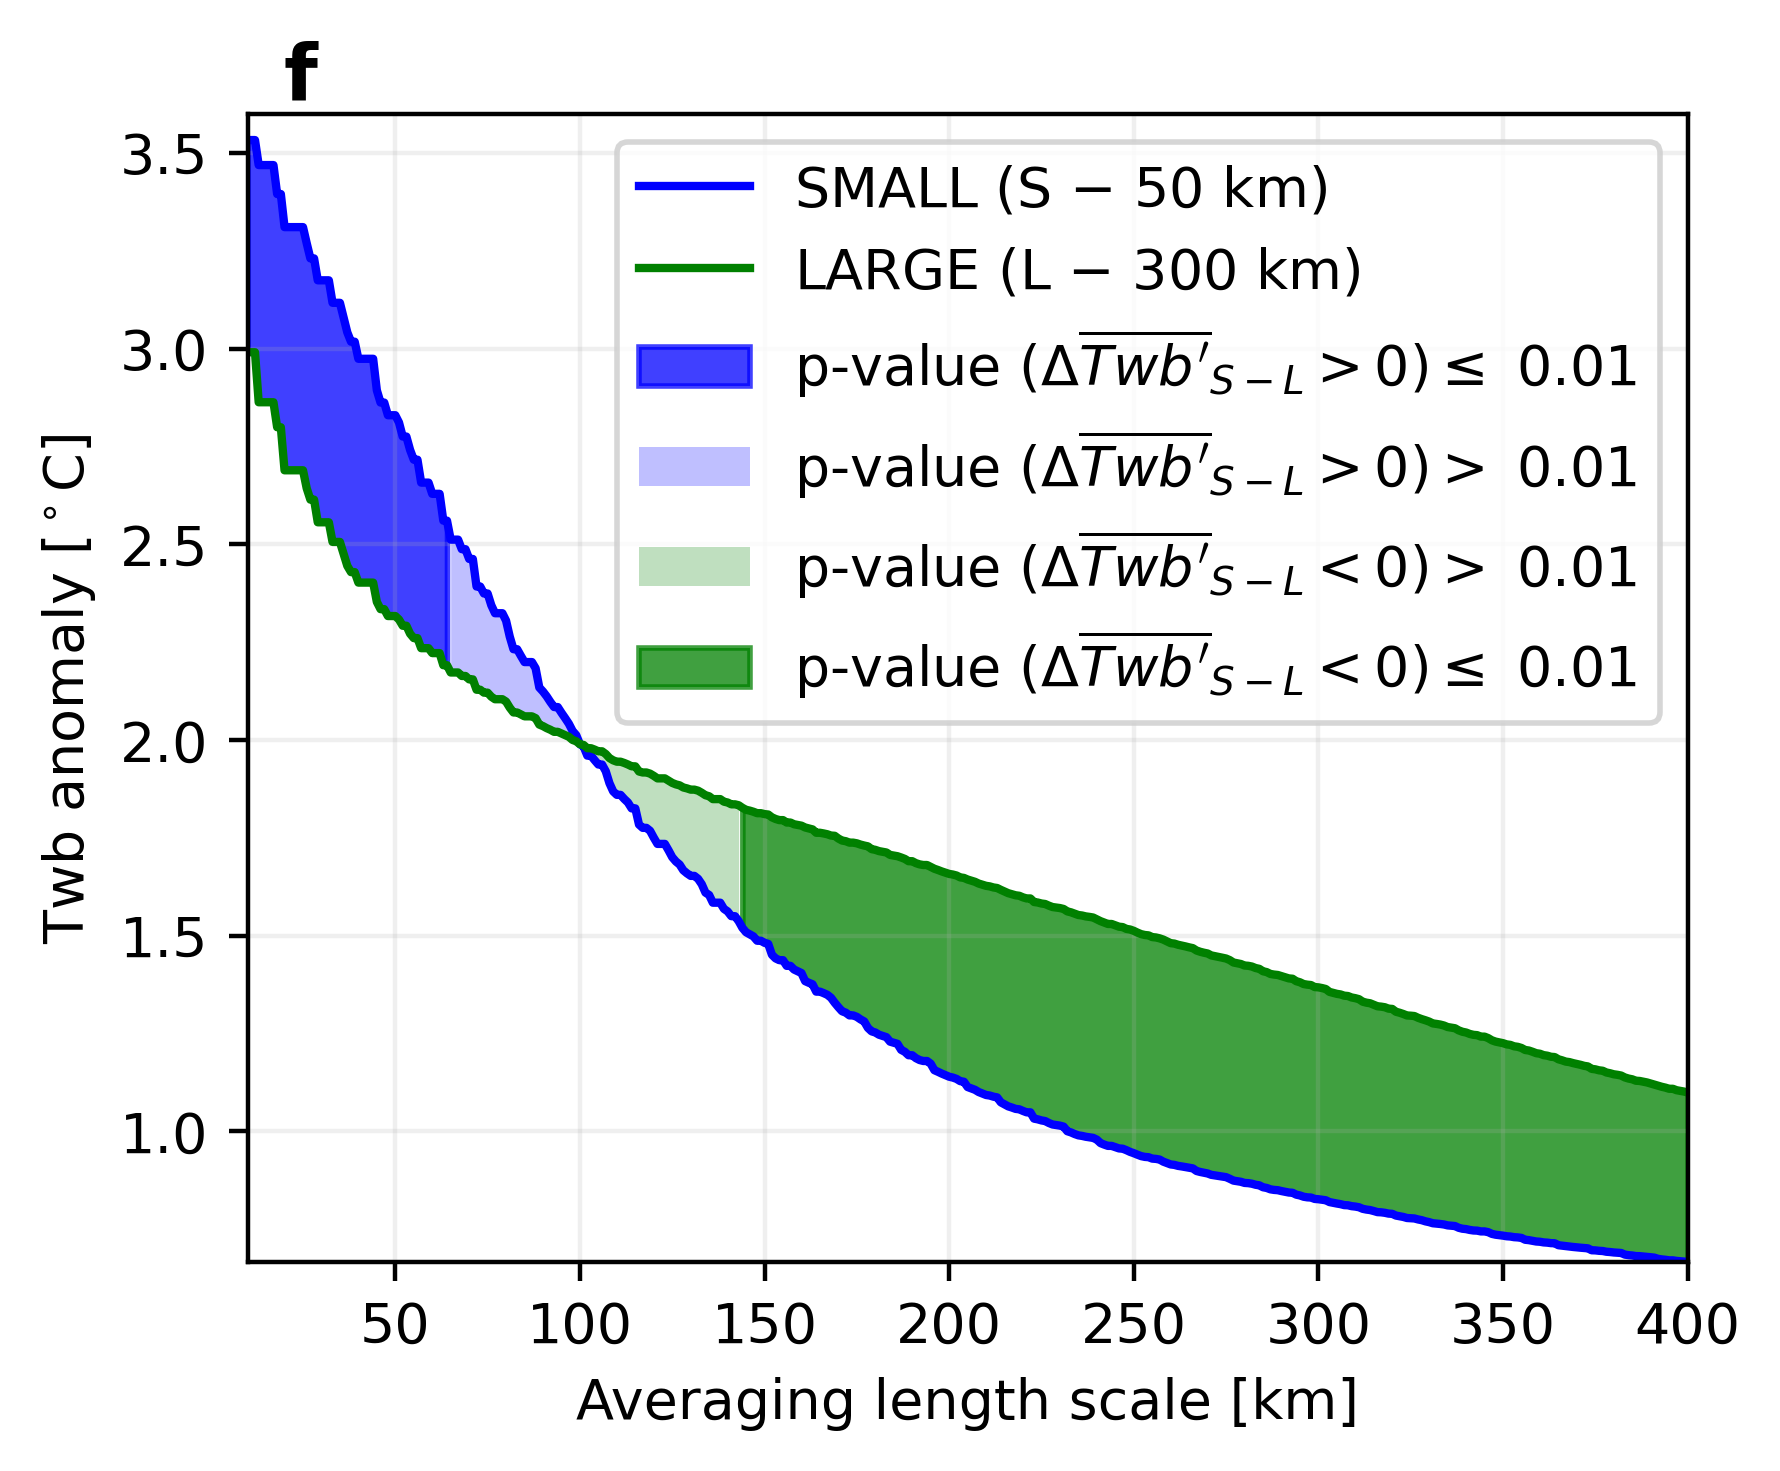

In [12]:
#~ Plot

ymin = min(abs(disc_mean_small.min()), abs(disc_mean_large.min()))
ymax = 3.6  # max(abs(disc_mean_small.max()), abs(disc_mean_large.max()))

mindiff = min(abs(disc_mean_diff))
if mindiff in disc_mean_diff:
    mindiff = mindiff
else:
	mindiff = - mindiff

imindiff = np.where(disc_mean_diff == mindiff)[0][0]


line_diff = Line2D([0], [0], label='SMALL$-$LARGE ($\Delta \overline{Twb}_{(S-L)}$)', color='k')
point_sig = Line2D([0], [0], label='p-value $(\Delta \overline{Twb}_{(S-L)}) \leq$ %.2f'%pvalue, marker='.', markersize=5,
     markeredgecolor='k', markerfacecolor='k', linestyle='')


fig, ax = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.125, top=0.945)

ax.plot(ave_lens, disc_mean_small, color='b', label='SMALL (S $-$ 50 km)')
ax.plot(ave_lens, disc_mean_large, color='g', label='LARGE (L $-$ 300 km)')

ax.fill_between(ave_lens[isigsmall], disc_mean_small[isigsmall], disc_mean_large[isigsmall], color='b', alpha=0.75, label="p-value ($\Delta \overline{Twb'}_{S-L} > 0) \leq$ %.2f"%pvalue)
ax.fill_between(ave_lens[inosigsmall], disc_mean_small[inosigsmall], disc_mean_large[inosigsmall], linewidths=0., color='b', alpha=0.25, label="p-value ($\Delta \overline{Twb'}_{S-L} > 0) >$ %.2f"%pvalue)
ax.fill_between(ave_lens[inosiglarge], disc_mean_small[inosiglarge], disc_mean_large[inosiglarge], linewidths=0., color='g', alpha=0.25, label="p-value ($\Delta \overline{Twb'}_{S-L} < 0) >$ %.2f"%pvalue)
ax.fill_between(ave_lens[isiglarge], disc_mean_large[isiglarge], disc_mean_small[isiglarge], color='g', alpha=0.75, label="p-value ($\Delta \overline{Twb'}_{S-L} < 0) \leq$ %.2f"%pvalue)

xtcks = ax.get_xticks()[1:-1]
xtlbs = [str(int(xt*2)) for xt in xtcks]

ax.text(0.025, 1.0125, flabel, weight="bold", fontsize=14, transform=ax.transAxes)

ax.set_xticks(xtcks)
ax.set_xticklabels(xtlbs)
ax.set_xlim(ave_lens[0], ave_lens[-1])
ax.set_xlabel('Averaging length scale [km]')
ax.set_ylim(ymin, ymax)
ax.set_ylabel("Twb anomaly [$^\circ$C]")
ax.grid(True, alpha=0.2)

ax.legend()

fig.set_size_inches(4.5, 3.5)